In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#step 1b

import os
#print(os.listdir('/kaggle/input/multitask-music-classification-2020/patreco3-affective-multitask-music/'))
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train_labels.txt
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/5700.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/1866.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/7493.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/8833.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/3295.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/9210.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/6457.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train/5260.fused.full.npy
/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat/train

In [2]:
import librosa.display

(140, 1291)
(140, 1292)


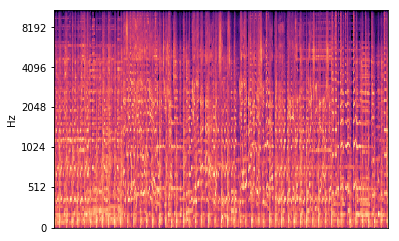

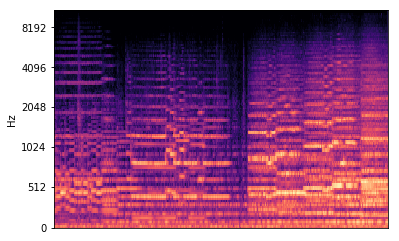

In [0]:
#step 1

import matplotlib.pyplot as plt
#label-> blues
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/1043.fused.full.npy')
print(spec1.shape)
plt.figure(1)
mel1, chroma1 = spec1[:128], spec1[128:]
librosa.display.specshow(mel1,y_axis='mel')
#label->classical
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/10035.fused.full.npy')
print(spec2.shape)
mel2, chroma2 = spec2[:128], spec2[128:]
plt.figure(2)
librosa.display.specshow(mel2,y_axis='mel')

(140, 53)
(140, 67)


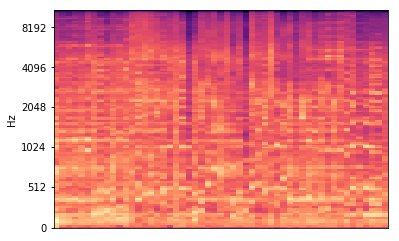

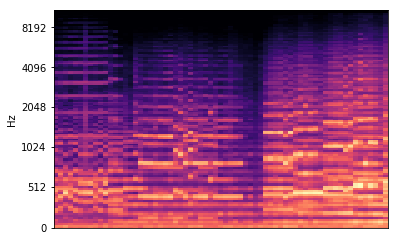

In [0]:
#step 2

#label-> blues
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/1043.fused.full.npy')
print(spec1.shape)
plt.figure(1)
mel1, chroma1_beat = spec1[:128], spec1[128:]
librosa.display.specshow(mel1,y_axis='mel')
#label->classical
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/10035.fused.full.npy')
print(spec2.shape)
mel2, chroma2_beat = spec2[:128], spec2[128:]
plt.figure(2)
librosa.display.specshow(mel2,y_axis='mel')

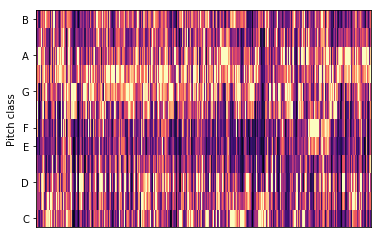

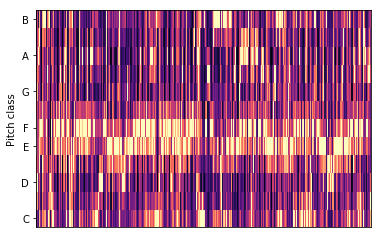

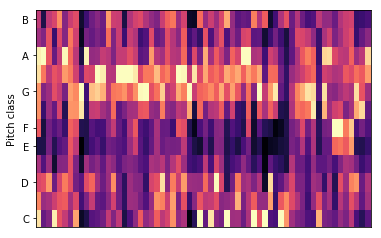

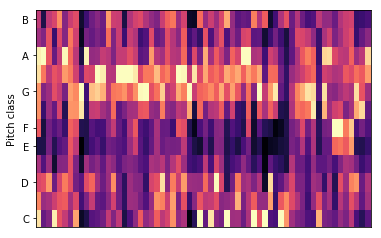

In [0]:
#step 3
plt.figure(3)
librosa.display.specshow(chroma1,y_axis='chroma')
plt.figure(4)
librosa.display.specshow(chroma2,y_axis='chroma')
plt.figure(5)
librosa.display.specshow(chroma1_beat,y_axis='chroma')
plt.figure(6)
librosa.display.specshow(chroma2_beat,y_axis='chroma')

In [6]:
#step 4

#custom pytorch dataset
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

#split dataset --create train and validation set 
def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    #validation->20% of test data
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    #SubsetRandomSampler samples elements randomly from a given list of indices, without replacement.
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    #we use the custom sampler
    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              drop_last=True,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            drop_last=True,
                            sampler=val_sampler)
    return train_loader, val_loader

def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T

def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


#padding is needed so that all samples have the same length
class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

class SpectrogramDataset(Dataset):
    def __init__(self, path, task=None, train=True, max_length=-1, read_spec_fn=read_mel_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, task)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(np.array(labels).astype('float'))

    def get_files_labels(self, txt, task):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if task=='valence':
                label = l[1]
            elif task=='energy':
                label = l[2]
            else:
                label = l[3]
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self): #returns lenght
        return len(self.labels)

In [7]:
#custom pytorch dataset
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re

# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}



class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class SpectrogramDatasetCategory(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_mel_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)
    


{'Rock': 160, 'Pop': 160, 'Chiptune': 160, 'Psych-Folk': 160, 'International': 160, 'Punk': 160, 'Indie-Rock': 160, 'Psych-Rock': 160, 'Post-Rock': 95, 'Classical': 160, 'Soundtrack': 124, 'Old-Time': 160, 'Blues': 160, 'Metal': 153, 'Post-Punk': 160, 'Jazz': 160, 'Hip-Hop': 160, 'Folk': 160, 'Trip-Hop': 137, 'Electronic': 160}


<BarContainer object of 10 artists>

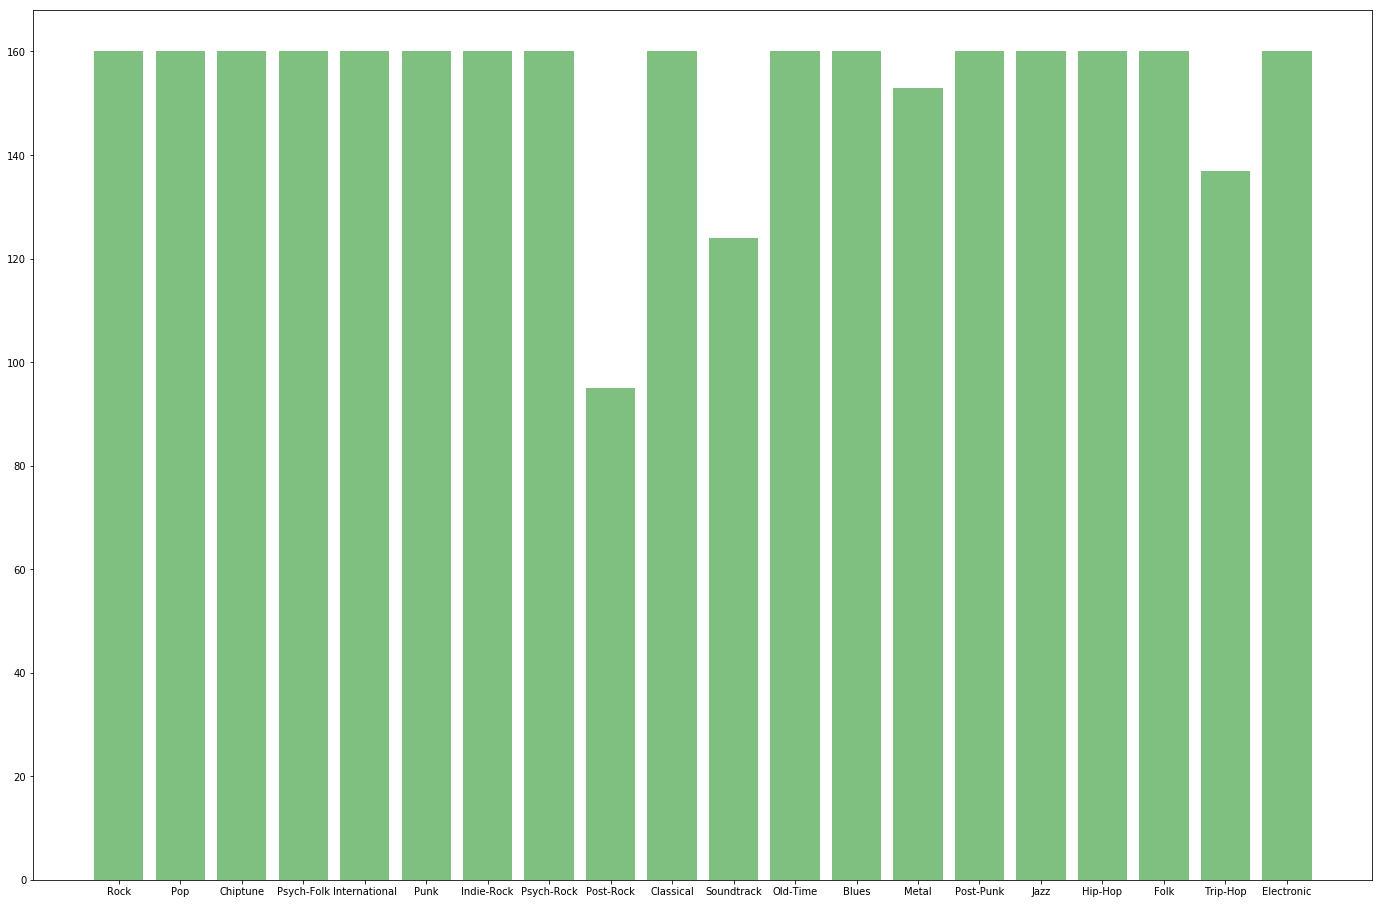

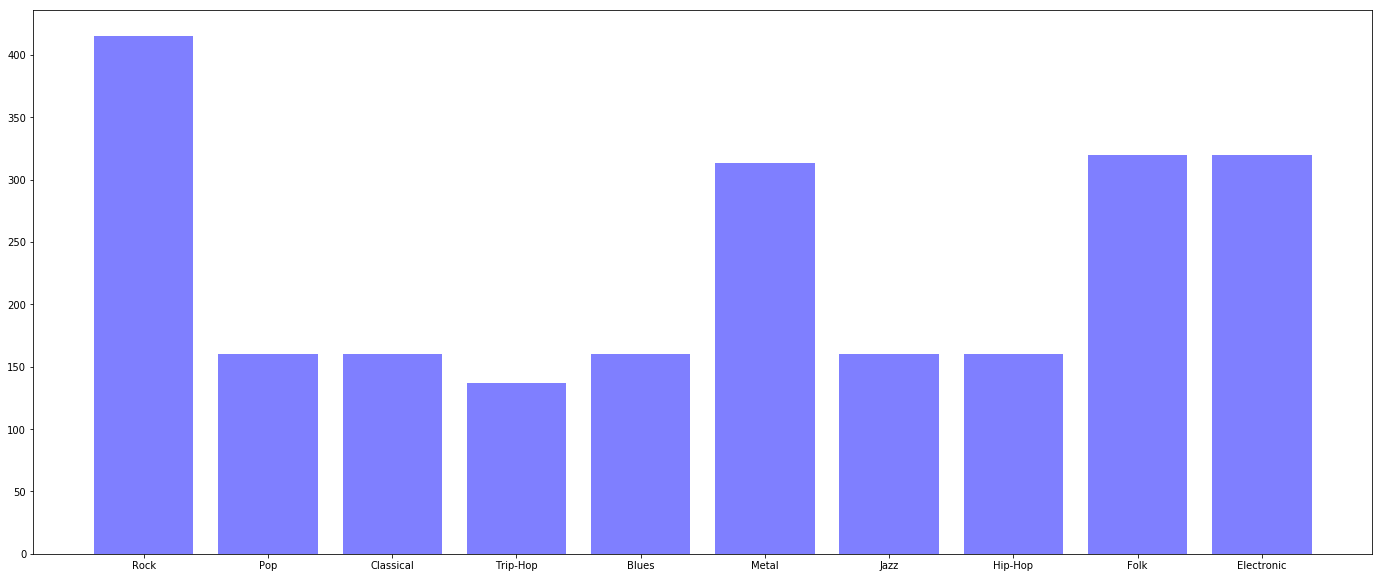

In [8]:
#step 4c
import numpy as np
import matplotlib.pyplot as plt

#class histogram before and after class mapping
classes_labels=(np.genfromtxt('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt',dtype='str'))[1:]
unique_classes=set(classes_labels[:,1])
unique_classes_am=set(class_mapping.values())
unique_classes_am.remove(None)
freq_dict= {s:0 for s in unique_classes}
freq_dict_am={s:0 for s in unique_classes_am}
for i in classes_labels[:,1]:
    freq_dict[i]+=1
    if (class_mapping[i]):
        freq_dict_am[class_mapping[i]]+=1
#before the mapping 
print(freq_dict)
fig = plt.figure(figsize = (24,16))
plt.bar(freq_dict.keys(),freq_dict.values(),align='center',color='green',alpha=0.5)
#after mapping
fig = plt.figure(figsize = (24,10))
plt.bar(freq_dict_am.keys(),freq_dict_am.values(),align='center',color='blue',alpha=0.5)

In [10]:
#for step 5a
#create a pytorch dataset for the mel spectogram

mel_specs = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
test_loader_mel = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_loader_mel,
                              batch_size=5,
                              drop_last=True)

In [9]:
#for step 5b
#create a pytorch dataset for the beat-synced mel spectogramm

beat_mel_specs = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
test_loader_beat_mel = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_beat_mel = DataLoader(test_loader_beat_mel,
                              batch_size=5,
                              drop_last=True)





In [11]:
#for step 5c
# create a pytorch dataset for the chromograms
chroma = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
train_loader_chroma, val_loader_chroma = torch_train_val_split(chroma, 32 ,32, val_size=.33)
test_loader_chroma = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
test_loader_chroma = DataLoader(test_loader_chroma,
                              batch_size=5,
                              drop_last=True)


In [11]:
#for step 5d
# create a pytorch dataset for the concatenated spectogram & chromogram

fused = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
train_loader_fused, val_loader_fused = torch_train_val_split(fused, 32 ,32, val_size=.33)
test_loader_fused = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
test_loader_fused = DataLoader(test_loader_fused,
                              batch_size=5,
                              drop_last=True)

In [13]:
#for step 8a
#create a pytorch dataset for the mel spectogram
mel_specs_energy = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         train=True,
         task='energy',
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_energy, test_loader_energy= torch_train_val_split(mel_specs_energy, 32 ,32, val_size= 0.2 )

mel_specs_valence = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         train=True,
         task='valence',
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_valence, test_loader_valence = torch_train_val_split(mel_specs_valence, 32 ,32, val_size= 0.2 )

mel_specs_danceability = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         train=True,
         task='danceability',
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_danceability, test_loader_danceability = torch_train_val_split(mel_specs_danceability, 32 ,32, val_size= 0.2 )

In [14]:
#step 5

import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers,drop_prob=0.2, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.direction = 2 if self.bidirectional else 1
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.rnn_size = rnn_size
        #lstm initialization
        self.lstm = nn.LSTM(input_dim,self.rnn_size, num_layers, dropout=drop_prob, batch_first=True, bidirectional=self.bidirectional)
        self.dropout = nn.Dropout(drop_prob)
        #linear layer /output_dimension = number of classes(10)
        self.fc = nn.Linear(self.feature_size, output_dim)

        
        # Initialize the LSTM, Dropout, Output layers
        

      
    def forward(self, x, lengths,hidden):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        
        
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        lstm_out, hidden = self.lstm(x, hidden)
        batch_size=x.shape[0]
        lstm_out = lstm_out.contiguous().view(batch_size,-1, self.feature_size)
        out = self.fc(lstm_out)
        #get last output for each sequence 
        last_outputs = self.last_timestep(out,lengths,self.bidirectional)
        return last_outputs,hidden

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)
  

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        new_lengths=np.array([length-1 for length in lengths],dtype='long')
        idx = (torch.from_numpy(new_lengths)).view(-1, 1)
        idx = idx.expand(outputs.size(0),outputs.size(2)).unsqueeze(1).to(device)
        return outputs.gather(1, idx).squeeze().to(device)

    def init_hidden(self, batch_size):
        #initialize hidden size 
        weight = next(self.parameters()).data
        hidden = (weight.new(self.direction*self.num_layers, batch_size, self.rnn_size).zero_().to(device),
                      weight.new(self.direction*self.num_layers, batch_size, self.rnn_size).zero_().to(device))
        return hidden

In [15]:
#we initialize and train our LSTM model--GPU has to be turned on to allow for faster computation times

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

def train_model(input_dim,output_dim,save_string,data_loader,val_loader=None,category=True,val=True):
    batch_size=32
    rnn_size = 128 #hidden size
    num_layers = 2 

    model = BasicLSTM(input_dim,rnn_size,output_dim,num_layers)
    model.to(device)
    lr=0.0001
    if (category):
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.001)
    epochs = 30
    print_every = 200
    valid_loss_min = np.Inf
    loss_values_train = []
    loss_values_val = []
    model.train()
    counter=0



    for i in range(epochs):
        running_loss_train=0.0
        running_loss_val=0.0
        h = model.init_hidden(batch_size)
        train_losses=[]
        for inputs, labels,lengths in data_loader:
            inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
            counter += 1
            h = tuple([e.data for e in h])
            model.zero_grad()
            output, h = model(inputs.float(),lengths,h)
            if (category):
                loss = criterion(output.squeeze(), labels.long())
            else:
                loss = criterion(output.squeeze(), labels.float())
            running_loss_train =+ loss.item() * batch_size
            train_losses.append(loss.item())

            loss.backward()
            #nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            if (counter%print_every == 0 and val):
              val_h = model.init_hidden(batch_size)
              val_losses = []
              model.eval()
              for inp, lab,lens in val_loader:
                  inp,lab,lens=inp.to(device),lab.to(device),lens.to(device)
                  val_h = tuple([each.data for each in val_h])
                  out, val_h = model(inp.float(),lens, val_h)
                  val_loss = criterion(out.squeeze(), lab.long())
                  val_losses.append(val_loss.item())
                  #running_loss_val=+ val_loss.item() * batch_size
              model.train()
              #'./state_mel_beat_dict.pt'
              if np.mean(val_losses) <= valid_loss_min:
                  torch.save(model.state_dict(), save_string)
                  print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                  valid_loss_min = np.mean(val_losses)
        if val:
            model.eval()
            val_h = model.init_hidden(batch_size) 
            validation_losses=[]
            for inp, lab,lens in val_loader:
                      inp,lab,lens=inp.to(device),lab.to(device),lens.to(device)
                      val_h = tuple([each.data for each in val_h])
                      out, val_h = model(inp.float(),lens, val_h)
                      val_loss = criterion(out.squeeze(), lab.long())
                      validation_losses.append(val_loss.item())
                      running_loss_val=+ val_loss.item() * batch_size

            model.train()
        print("Epoch: {}/{}...".format(i+1, epochs),
                "Step: {}...".format(counter),
                "Train Loss: {:.6f}...".format(loss.item()))
        loss_values_train.append(np.mean(train_losses))
        if (val):
            loss_values_val.append(np.mean(validation_losses))    
    plt.plot(range(epochs),loss_values_train)
    if (val):
        plt.plot(range(epochs),loss_values_val)
    if(not val):
        torch.save(model.state_dict(), save_string)

Epoch: 1/30... Step: 48... Train Loss: 2.172472...
Epoch: 2/30... Step: 96... Train Loss: 2.096755...
Epoch: 3/30... Step: 144... Train Loss: 1.995506...
Epoch: 4/30... Step: 192... Train Loss: 2.155095...
Validation loss decreased (inf --> 2.097287).  Saving model ...
Epoch: 5/30... Step: 240... Train Loss: 2.082451...
Epoch: 6/30... Step: 288... Train Loss: 2.047362...
Epoch: 7/30... Step: 336... Train Loss: 2.002221...
Epoch: 8/30... Step: 384... Train Loss: 2.136386...
Validation loss decreased (2.097287 --> 1.983752).  Saving model ...
Epoch: 9/30... Step: 432... Train Loss: 1.956170...
Epoch: 10/30... Step: 480... Train Loss: 2.314783...
Epoch: 11/30... Step: 528... Train Loss: 2.057459...
Epoch: 12/30... Step: 576... Train Loss: 2.079197...
Validation loss decreased (1.983752 --> 1.969740).  Saving model ...
Epoch: 13/30... Step: 624... Train Loss: 1.768616...
Epoch: 14/30... Step: 672... Train Loss: 2.109849...
Epoch: 15/30... Step: 720... Train Loss: 2.098317...
Epoch: 16/30..

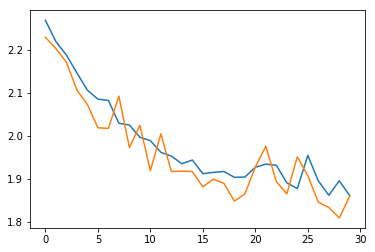

In [17]:
#step 5a
train_model(128,10,'./state_mel_dict.pt',train_loader_mel,val_loader_mel)

Epoch: 1/30... Step: 48... Train Loss: 2.150374...
Epoch: 2/30... Step: 96... Train Loss: 2.272028...
Epoch: 3/30... Step: 144... Train Loss: 1.991767...
Epoch: 4/30... Step: 192... Train Loss: 1.973524...
Validation loss decreased (inf --> 2.055736).  Saving model ...
Epoch: 5/30... Step: 240... Train Loss: 1.914253...
Epoch: 6/30... Step: 288... Train Loss: 2.045116...
Epoch: 7/30... Step: 336... Train Loss: 2.072339...
Epoch: 8/30... Step: 384... Train Loss: 2.055525...
Validation loss decreased (2.055736 --> 1.949779).  Saving model ...
Epoch: 9/30... Step: 432... Train Loss: 1.791921...
Epoch: 10/30... Step: 480... Train Loss: 1.792390...
Epoch: 11/30... Step: 528... Train Loss: 1.609482...
Epoch: 12/30... Step: 576... Train Loss: 2.052853...
Validation loss decreased (1.949779 --> 1.873882).  Saving model ...
Epoch: 13/30... Step: 624... Train Loss: 2.167714...
Epoch: 14/30... Step: 672... Train Loss: 1.890113...
Epoch: 15/30... Step: 720... Train Loss: 1.861818...
Epoch: 16/30..

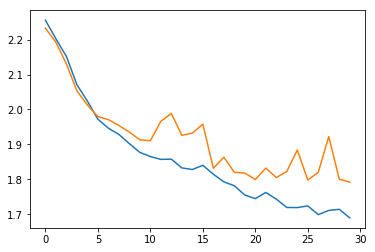

In [16]:
#step 5b
train_model(128,10,'./state_mel_beat_dict.pt',train_loader_beat_mel,val_loader_beat_mel)


Epoch: 1/30... Step: 48... Train Loss: 2.249518...
Epoch: 2/30... Step: 96... Train Loss: 2.186453...
Epoch: 3/30... Step: 144... Train Loss: 2.111959...
Epoch: 4/30... Step: 192... Train Loss: 2.275705...
Validation loss decreased (inf --> 2.201796).  Saving model ...
Epoch: 5/30... Step: 240... Train Loss: 2.247671...
Epoch: 6/30... Step: 288... Train Loss: 2.241696...
Epoch: 7/30... Step: 336... Train Loss: 2.188492...
Epoch: 8/30... Step: 384... Train Loss: 2.280958...
Epoch: 9/30... Step: 432... Train Loss: 2.238026...
Epoch: 10/30... Step: 480... Train Loss: 2.242508...
Epoch: 11/30... Step: 528... Train Loss: 2.104172...
Epoch: 12/30... Step: 576... Train Loss: 2.091013...
Validation loss decreased (2.201796 --> 2.198706).  Saving model ...
Epoch: 13/30... Step: 624... Train Loss: 2.232161...
Epoch: 14/30... Step: 672... Train Loss: 2.245134...
Epoch: 15/30... Step: 720... Train Loss: 2.187859...
Epoch: 16/30... Step: 768... Train Loss: 2.360372...
Validation loss decreased (2.1

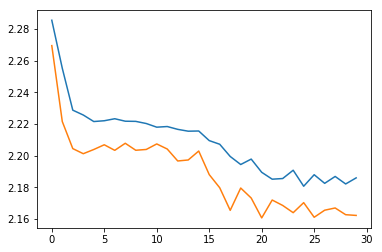

In [18]:
#step 5c
train_model(12,10,'./chroma_dict.pt',train_loader_chroma,val_loader_chroma)

Epoch: 1/40... Step: 48... Train Loss: 2.247308...
Epoch: 2/40... Step: 96... Train Loss: 2.143164...
Epoch: 3/40... Step: 144... Train Loss: 2.194408...
Epoch: 4/40... Step: 192... Train Loss: 2.005518...
Validation loss decreased (inf --> 2.086265).  Saving model ...
Epoch: 5/40... Step: 240... Train Loss: 1.930544...
Epoch: 6/40... Step: 288... Train Loss: 2.082797...
Epoch: 7/40... Step: 336... Train Loss: 2.085106...
Epoch: 8/40... Step: 384... Train Loss: 1.927711...
Validation loss decreased (2.086265 --> 2.018881).  Saving model ...
Epoch: 9/40... Step: 432... Train Loss: 1.976232...
Epoch: 10/40... Step: 480... Train Loss: 2.157146...
Epoch: 11/40... Step: 528... Train Loss: 1.934762...
Epoch: 12/40... Step: 576... Train Loss: 1.925969...
Validation loss decreased (2.018881 --> 1.937980).  Saving model ...
Epoch: 13/40... Step: 624... Train Loss: 2.036028...
Epoch: 14/40... Step: 672... Train Loss: 2.070441...
Epoch: 15/40... Step: 720... Train Loss: 1.928660...
Epoch: 16/40..

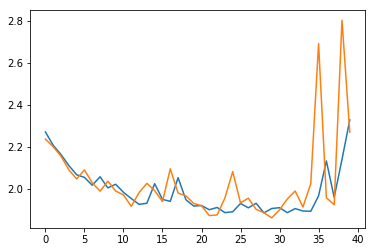

In [17]:
#step 5d
train_model(140,'./fused_dict.pt',train_loader_fused,val_loader_fused)

In [20]:
#step 6
#we test our model
def test(input_dim,save_file,test_loader):
    model = BasicLSTM(input_dim,128,10,2)
    model.to(device)
    criterion=nn.CrossEntropyLoss()
    model.load_state_dict(torch.load(save_file))
    batch_size=5
    test_losses = []
    num_correct = 0
    h = model.init_hidden(batch_size)
    correct=0
    y_pred_test=[]
    y_true=[]
    model.eval()
    for inputs, labels,lengths in test_loader:
          inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
          h = tuple([each.data for each in h])
          output, h = model(inputs.float(),lengths, h)
          test_loss = criterion(output.squeeze(), labels.long())
          test_losses.append(test_loss.item())
          pred = output.data.max(1)[1]  # get the index of the max log-probability
          y_pred_test.append(pred.tolist())
          y_true.append(labels.tolist())
          correct += pred.eq(labels.data).sum()

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              np.mean(test_losses), correct, len(test_loader.dataset),
              100. * correct / (len(test_loader.dataset))))

    #test on different metrics
    #precision,recall, F1 score for each class
    print(np.array(y_true).shape)
    print(np.array(y_pred_test).shape)
    from sklearn.metrics import classification_report
    print(classification_report(np.array(y_true).flatten(),np.array(y_pred_test).flatten()))


In [22]:
#model with spectograms as input
test(128,'./state_mel_dict.pt',test_loader_mel)


Test set: Average loss: 1.927896, Accuracy: 177/575 (31%)

(115, 5)
(115, 5)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.33      0.62      0.43        40
           2       0.28      0.50      0.36        80
           3       0.24      0.51      0.33        80
           4       0.50      0.03      0.05        40
           5       0.00      0.00      0.00        40
           6       0.48      0.28      0.35        78
           7       0.00      0.00      0.00        40
           8       0.34      0.47      0.39       103
           9       0.00      0.00      0.00        34

    accuracy                           0.31       575
   macro avg       0.22      0.24      0.19       575
weighted avg       0.26      0.31      0.25       575



In [21]:
#model with beat-synced spectograms as input
test(128,'./state_mel_beat_dict.pt',test_loader_beat_mel)


Test set: Average loss: 1.835892, Accuracy: 213/575 (37%)

(115, 5)
(115, 5)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.49      0.53      0.51        40
           2       0.36      0.68      0.47        80
           3       0.34      0.61      0.44        80
           4       0.22      0.20      0.21        40
           5       0.20      0.10      0.13        40
           6       0.48      0.62      0.54        78
           7       0.00      0.00      0.00        40
           8       0.39      0.27      0.32       103
           9       0.12      0.03      0.05        34

    accuracy                           0.37       575
   macro avg       0.26      0.30      0.27       575
weighted avg       0.30      0.37      0.32       575



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
#model with chromagrams as input
test(12,'./chroma_dict.pt',test_loader_chroma)


Test set: Average loss: 2.181300, Accuracy: 114/575 (20%)

(115, 5)
(115, 5)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.20      0.68      0.31        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.23      0.29      0.26        78
           7       0.00      0.00      0.00        40
           8       0.19      0.36      0.25       103
           9       0.00      0.00      0.00        34

    accuracy                           0.20       575
   macro avg       0.06      0.13      0.08       575
weighted avg       0.09      0.20      0.12       575



In [22]:
#model with concatenated spectograms and chromograms as input
test(140,'./fused_dict.pt',test_loader_fused)


Test set: Average loss: 1.899475, Accuracy: 196/575 (34%)

(115, 5)
(115, 5)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.39      0.60      0.48        40
           2       0.30      0.75      0.42        80
           3       0.36      0.40      0.38        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.44      0.36      0.39        78
           7       0.00      0.00      0.00        40
           8       0.33      0.50      0.40       103
           9       0.00      0.00      0.00        34

    accuracy                           0.34       575
   macro avg       0.18      0.26      0.21       575
weighted avg       0.24      0.34      0.27       575



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/30... Step: 7... Train Loss: 0.176380...
Epoch: 2/30... Step: 14... Train Loss: 0.084386...
Epoch: 3/30... Step: 21... Train Loss: 0.065087...
Epoch: 4/30... Step: 28... Train Loss: 0.067690...
Epoch: 5/30... Step: 35... Train Loss: 0.048998...
Epoch: 6/30... Step: 42... Train Loss: 0.058066...
Epoch: 7/30... Step: 49... Train Loss: 0.053365...
Epoch: 8/30... Step: 56... Train Loss: 0.065707...
Epoch: 9/30... Step: 63... Train Loss: 0.033732...
Epoch: 10/30... Step: 70... Train Loss: 0.038909...
Epoch: 11/30... Step: 77... Train Loss: 0.046232...
Epoch: 12/30... Step: 84... Train Loss: 0.038658...
Epoch: 13/30... Step: 91... Train Loss: 0.022752...
Epoch: 14/30... Step: 98... Train Loss: 0.058851...
Epoch: 15/30... Step: 105... Train Loss: 0.036905...
Epoch: 16/30... Step: 112... Train Loss: 0.044039...
Epoch: 17/30... Step: 119... Train Loss: 0.035656...
Epoch: 18/30... Step: 126... Train Loss: 0.036412...
Epoch: 19/30... Step: 133... Train Loss: 0.034768...
Epoch: 20/30... S

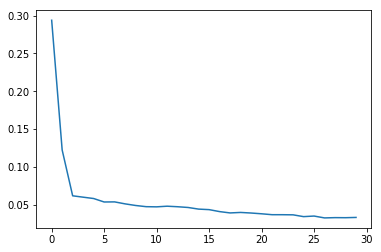

In [25]:
#for step 8c
#We train our model on the three different tasks of the multitask dataset

train_model(128,1,'./state_mel_energy_multi.pt',test_loader_energy,val=False,category=False)

Epoch: 1/30... Step: 7... Train Loss: 0.199747...
Epoch: 2/30... Step: 14... Train Loss: 0.092883...
Epoch: 3/30... Step: 21... Train Loss: 0.066588...
Epoch: 4/30... Step: 28... Train Loss: 0.052649...
Epoch: 5/30... Step: 35... Train Loss: 0.065224...
Epoch: 6/30... Step: 42... Train Loss: 0.064507...
Epoch: 7/30... Step: 49... Train Loss: 0.065074...
Epoch: 8/30... Step: 56... Train Loss: 0.052368...
Epoch: 9/30... Step: 63... Train Loss: 0.055449...
Epoch: 10/30... Step: 70... Train Loss: 0.038669...
Epoch: 11/30... Step: 77... Train Loss: 0.074379...
Epoch: 12/30... Step: 84... Train Loss: 0.052981...
Epoch: 13/30... Step: 91... Train Loss: 0.045892...
Epoch: 14/30... Step: 98... Train Loss: 0.052597...
Epoch: 15/30... Step: 105... Train Loss: 0.060116...
Epoch: 16/30... Step: 112... Train Loss: 0.051229...
Epoch: 17/30... Step: 119... Train Loss: 0.068142...
Epoch: 18/30... Step: 126... Train Loss: 0.053375...
Epoch: 19/30... Step: 133... Train Loss: 0.050265...
Epoch: 20/30... S

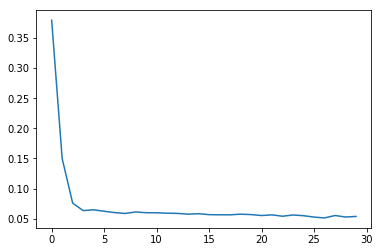

In [26]:
#for step 8b
train_model(128,1,'./state_mel_valence_multi.pt',test_loader_valence,val=False,category=False)

Epoch: 1/30... Step: 7... Train Loss: 0.202467...
Epoch: 2/30... Step: 14... Train Loss: 0.074960...
Epoch: 3/30... Step: 21... Train Loss: 0.028581...
Epoch: 4/30... Step: 28... Train Loss: 0.045404...
Epoch: 5/30... Step: 35... Train Loss: 0.037440...
Epoch: 6/30... Step: 42... Train Loss: 0.039520...
Epoch: 7/30... Step: 49... Train Loss: 0.028759...
Epoch: 8/30... Step: 56... Train Loss: 0.038655...
Epoch: 9/30... Step: 63... Train Loss: 0.027995...
Epoch: 10/30... Step: 70... Train Loss: 0.029697...
Epoch: 11/30... Step: 77... Train Loss: 0.037299...
Epoch: 12/30... Step: 84... Train Loss: 0.027952...
Epoch: 13/30... Step: 91... Train Loss: 0.027539...
Epoch: 14/30... Step: 98... Train Loss: 0.040264...
Epoch: 15/30... Step: 105... Train Loss: 0.033877...
Epoch: 16/30... Step: 112... Train Loss: 0.032740...
Epoch: 17/30... Step: 119... Train Loss: 0.016904...
Epoch: 18/30... Step: 126... Train Loss: 0.032203...
Epoch: 19/30... Step: 133... Train Loss: 0.038010...
Epoch: 20/30... S

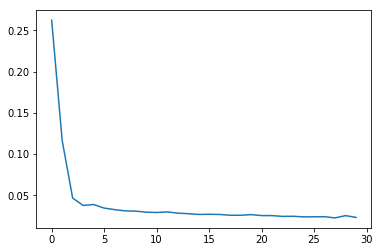

In [27]:
#for step 8d
train_model(128,1,'./state_mel_danceability_multi.pt',test_loader_danceability,val=False,category=False)

In [28]:
#for step 8e
import scipy.stats


def test_lstm_model_multitask(test_loader,save_file):
    model_lstm = BasicLSTM (128,128,1,2)
    model_lstm.to(device)
    model_lstm.load_state_dict(torch.load(save_file))
    batch_size=32
    h = model_lstm.init_hidden(batch_size)
    test_losses = []
    y_pred_test=[]
    y_true=[]
    model_lstm.eval()
    for inputs, labels,lengths in test_loader:
          inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
          h = tuple([each.data for each in h])
          output, h = model_lstm(inputs.float(),lengths, h)
          y_pred_test.append(output.data.tolist())
          y_true.append(labels.tolist())
    rho= scipy.stats.spearmanr(np.array(y_true).flatten(),np.array(y_pred_test).flatten()).correlation
    print('\nTest set: Spearman Correlation: {:.6f} \n'.format(rho))
    return rho

rho_energy=test_lstm_model_multitask(test_loader_energy,'./state_mel_energy_multi.pt')
rho_valence=test_lstm_model_multitask(test_loader_valence,'./state_mel_valence_multi.pt')
rho_danceability = test_lstm_model_multitask(test_loader_danceability,'./state_mel_danceability_multi.pt')
print((rho_energy+rho_valence+rho_danceability)/3)


Test set: Spearman Correlation: 0.714663 


Test set: Spearman Correlation: 0.421551 


Test set: Spearman Correlation: 0.603529 

0.57991442642793


In [2]:
import torch
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
#defined again

mel_specs_category = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs_category, 16 ,16, val_size= 0 )
test_loader_mel = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_loader_mel,
                              batch_size=5,
                              drop_last=True)

In [5]:
mel_specs_category = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs_category, 16 ,16, val_size= 0 )
test_loader_mel = SpectrogramDatasetCategory(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_loader_mel,
                              batch_size=5,
                              drop_last=True)

In [7]:
#step 7 (b)

import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

#CNN parameters initinialization
class FancyCNN(nn.Module):
    def __init__(self):
        super(FancyCNN,self).__init__()
        self._cnn_module = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            Flatten()
        
        )
        self._fc_module = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10240, out_features=1)
        )
        #applies initialize weights to every submodule of nn.Sequential--we are only interested in linear and convolutional layer
        #self.apply(self.initialize_weights)

    def forward(self, x):
        #we want x to have dimensions [batch_size,1,]
        x=x.transpose(1,2)
        x=torch.unsqueeze(x,1)
        for layer in self._cnn_module:
            x = layer(x)
        
        for layer in self._fc_module:
            x=layer(x)
        return x
    def initialize_weights(self,layer)->None:
        if isinstance(layer, nn.Conv2d):
            #weights are drawn from a zero mean Gaussian with std sqrt(2/nj) nj-> number of neurons (kaiming he initialization)
            nn.init.kaiming_uniform_(layer.weight)
        elif isinstance(layer, nn.Linear):
            #we use xavier initialization
            nn.init.xavier_uniform_(layer.weight)


In [8]:
import matplotlib.pyplot as plt
def train_cnn(data_loader,save_string,epochs,category=False):
    model_cnn = FancyCNN()
    if category:
        model_cnn._fc_module = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10240, out_features=10)
        )
    
    batch_size=16
    output_dim = 1

    model_cnn.to(device)
    lr=0.001
    if category:
        criterion=nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr,weight_decay=0.0001)

    train_loss_min = np.Inf
    loss_values_train = []
    loss_values_val = []
    model_cnn.train()
    counter=0
    


    model_cnn.train()    
    for i in range(epochs):
        running_loss_train=0.0
        running_loss_val=0.0
        train_losses=[]
        for inputs, labels,lengths in data_loader:
            inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
            counter += 1
            model_cnn.zero_grad()
            output =  model_cnn(inputs.float())
            if category:
                loss = criterion(output.squeeze(), labels.long())
            else:
                loss = criterion(output.squeeze(), labels.float())
            running_loss_train =+ loss.item() * batch_size
            train_losses.append(loss.item())

            loss.backward()

            optimizer.step()


        model_cnn.eval()
        model_cnn.train()
        print("Epoch: {}/{}...".format(i+1, epochs),
                "Step: {}...".format(counter),
                "Train Loss: {:.6f}...".format(loss.item()))
        loss_values_train.append(np.mean(train_losses))
        if np.mean(train_losses)<train_loss_min:
            torch.save(model_cnn.state_dict(),save_string)
    plt.plot(range(epochs),loss_values_train)
    #torch.save(model_cnn.state_dict(),save_string)
    




Epoch: 1/45... Step: 144... Train Loss: 2.730336...
Epoch: 2/45... Step: 288... Train Loss: 2.249630...
Epoch: 3/45... Step: 432... Train Loss: 2.079845...
Epoch: 4/45... Step: 576... Train Loss: 2.062719...
Epoch: 5/45... Step: 720... Train Loss: 2.344090...
Epoch: 6/45... Step: 864... Train Loss: 1.755060...
Epoch: 7/45... Step: 1008... Train Loss: 1.406715...
Epoch: 8/45... Step: 1152... Train Loss: 1.592322...
Epoch: 9/45... Step: 1296... Train Loss: 1.275243...
Epoch: 10/45... Step: 1440... Train Loss: 2.065856...
Epoch: 11/45... Step: 1584... Train Loss: 1.505134...
Epoch: 12/45... Step: 1728... Train Loss: 1.643165...
Epoch: 13/45... Step: 1872... Train Loss: 0.887365...
Epoch: 14/45... Step: 2016... Train Loss: 1.036636...
Epoch: 15/45... Step: 2160... Train Loss: 1.243826...
Epoch: 16/45... Step: 2304... Train Loss: 1.026699...
Epoch: 17/45... Step: 2448... Train Loss: 1.225366...
Epoch: 18/45... Step: 2592... Train Loss: 0.987388...
Epoch: 19/45... Step: 2736... Train Loss: 0

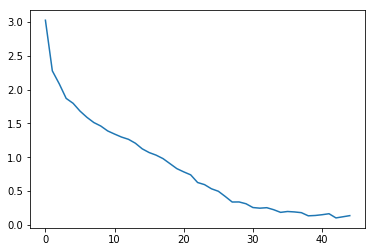

In [9]:
# we train our cnn model 

train_cnn(train_loader_mel,'state_mel_cnn.pt',epochs=45,category=True)


In [10]:
#step 7d

from sklearn.metrics import classification_report
# accuracy for simple CNN model

def cnn_test(save_file,test_loader):
    criterion=nn.CrossEntropyLoss()
    model_cnn = FancyCNN()
    model_cnn._fc_module = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10240, out_features=10)
    )
    model_cnn.to(device)
    model_cnn.load_state_dict(torch.load(save_file))
    batch_size=5
    test_losses = []
    num_correct = 0
    correct=0
    y_pred_test=[]
    y_true=[]
    model_cnn.eval()
    for inputs, labels,lengths in test_loader:
          inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
          output = model_cnn(inputs.float())
          test_loss = criterion(output.squeeze(), labels.long())
          test_losses.append(test_loss.item())
          pred = output.data.max(1)[1]  # get the index of the max log-probability
          y_pred_test.append(pred.tolist())
          y_true.append(labels.tolist())
          correct += pred.eq(labels.data).sum()

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              np.mean(test_losses), correct, len(test_loader.dataset),
              100. * correct / (len(test_loader.dataset))))
    print(classification_report(np.array(y_true).flatten(),np.array(y_pred_test).flatten()))
cnn_test('./state_mel_cnn.pt',test_loader_mel)


Test set: Average loss: 2.545818, Accuracy: 269/575 (47%)

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        40
           1       0.68      0.65      0.67        40
           2       0.66      0.56      0.61        80
           3       0.45      0.35      0.39        80
           4       0.65      0.70      0.67        40
           5       0.39      0.40      0.40        40
           6       0.54      0.59      0.56        78
           7       0.11      0.07      0.09        40
           8       0.39      0.53      0.45       103
           9       0.38      0.26      0.31        34

    accuracy                           0.47       575
   macro avg       0.45      0.45      0.45       575
weighted avg       0.47      0.47      0.46       575



Epoch: 1/30... Step: 56... Train Loss: 0.304178...
Epoch: 2/30... Step: 112... Train Loss: 1.210883...
Epoch: 3/30... Step: 168... Train Loss: 0.350180...
Epoch: 4/30... Step: 224... Train Loss: 0.510329...
Epoch: 5/30... Step: 280... Train Loss: 0.396430...
Epoch: 6/30... Step: 336... Train Loss: 0.179365...
Epoch: 7/30... Step: 392... Train Loss: 0.155270...
Epoch: 8/30... Step: 448... Train Loss: 0.343144...
Epoch: 9/30... Step: 504... Train Loss: 0.217448...
Epoch: 10/30... Step: 560... Train Loss: 0.115085...
Epoch: 11/30... Step: 616... Train Loss: 0.233282...
Epoch: 12/30... Step: 672... Train Loss: 0.235500...
Epoch: 13/30... Step: 728... Train Loss: 0.234014...
Epoch: 14/30... Step: 784... Train Loss: 0.073474...
Epoch: 15/30... Step: 840... Train Loss: 0.083874...
Epoch: 16/30... Step: 896... Train Loss: 0.142854...
Epoch: 17/30... Step: 952... Train Loss: 0.118657...
Epoch: 18/30... Step: 1008... Train Loss: 0.114130...
Epoch: 19/30... Step: 1064... Train Loss: 0.105069...
E

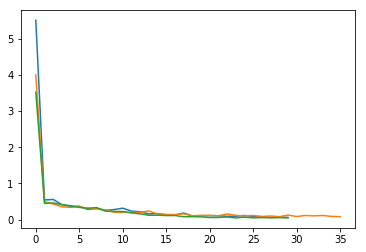

In [11]:
#for step 8b,c,d
# we train our cnn model on the 3 seperate learning tasks

train_cnn(train_loader_energy,'state_mel_energy_cnn.pt',epochs=30)

train_cnn(train_loader_valence,'state_mel_valence_cnn.pt',epochs=36)

train_cnn(train_loader_danceability,'state_mel_danceability_cnn.pt',epochs=30)



In [12]:
#step 8e
#we will now test our cnn model for the mutitask dataset
import scipy.stats


def test_cnn_model_multitask(test_loader,save_file):
    model_cnn=FancyCNN()
    model_cnn.to(device)
    model_cnn.load_state_dict(torch.load(save_file))
    batch_size=5
    test_losses = []
    y_pred_test=[]
    y_true=[]
    model_cnn.eval()
    for inputs, labels,lengths in test_loader:
          inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
          output = model_cnn(inputs.float())
          y_pred_test.append(output.data.tolist())
          y_true.append(labels.tolist())
    rho= scipy.stats.spearmanr(np.array(y_true).flatten(),np.array(y_pred_test).flatten()).correlation
    print('\nTest set: Spearman Correlation: {:.6f} \n'.format(rho))
    return rho

rho_energy=test_cnn_model_multitask(test_loader_energy,'./state_mel_energy_cnn.pt')
rho_valence=test_cnn_model_multitask(test_loader_valence,'./state_mel_valence_cnn.pt')
rho_danceability = test_cnn_model_multitask(test_loader_danceability,'./state_mel_danceability_cnn.pt')
print((rho_energy+rho_valence+rho_danceability)/3)




Test set: Spearman Correlation: 0.757193 


Test set: Spearman Correlation: 0.569181 


Test set: Spearman Correlation: 0.621002 

0.6491253766780033


In [ ]:
#step 8 has accumulatively been executed among the previous cells

#step 9a_c has already been executed along with step 7b

Epoch: 1/20... Step: 56... Train Loss: 0.277782...
Epoch: 2/20... Step: 112... Train Loss: 0.264503...
Epoch: 3/20... Step: 168... Train Loss: 0.269898...
Epoch: 4/20... Step: 224... Train Loss: 0.496721...
Epoch: 5/20... Step: 280... Train Loss: 0.319128...
Epoch: 6/20... Step: 336... Train Loss: 0.341733...
Epoch: 7/20... Step: 392... Train Loss: 0.318733...
Epoch: 8/20... Step: 448... Train Loss: 0.265691...
Epoch: 9/20... Step: 504... Train Loss: 0.294109...
Epoch: 10/20... Step: 560... Train Loss: 0.238833...
Epoch: 11/20... Step: 616... Train Loss: 0.177787...
Epoch: 12/20... Step: 672... Train Loss: 0.297863...
Epoch: 13/20... Step: 728... Train Loss: 0.198358...
Epoch: 14/20... Step: 784... Train Loss: 0.209074...
Epoch: 15/20... Step: 840... Train Loss: 0.304319...
Epoch: 16/20... Step: 896... Train Loss: 0.193282...
Epoch: 17/20... Step: 952... Train Loss: 0.341705...
Epoch: 18/20... Step: 1008... Train Loss: 0.102644...
Epoch: 19/20... Step: 1064... Train Loss: 0.157462...
E

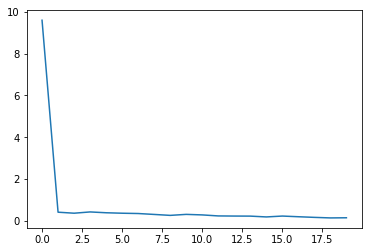

In [13]:
#step 9a_d

#for the transfer learning part we will employ a fine tuning strategy

model_ft = FancyCNN()
model_ft.to(device)
model_ft._fc_module = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10240, out_features=10)
    )
model_ft.load_state_dict(torch.load('./state_mel_cnn.pt'))

#we can try a freeze approach
for param in model_ft.parameters():
    param.requires_grad = False
model_ft._fc_module = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10240, out_features=1)
    )

#then we will train our model for a few epochs using the multitask dataset

# we train our cnn model on the 3 seperate learning tasks

train_cnn(train_loader_energy,'state_mel_energy_cnn.pt',epochs=20)

#train_cnn(train_loader_valence,'state_mel_valence_cnn.pt',epochs=20)

#train_cnn(train_loader_danceability,'state_mel_danceability_cnn.pt',epochs=30)


rho_energy=test_cnn_model_multitask(test_loader_energy,'./state_mel_energy_cnn.pt')
#rho_valence=test_cnn_model_multitask(test_loader_valence,'./state_mel_valence_cnn.pt')
#rho_danceability = test_cnn_model_multitask(test_loader_danceability,'./state_mel_danceability_cnn.pt')
#print((rho_energy+rho_valence+rho_danceability)/3)



Epoch: 1/50... Step: 56... Train Loss: 0.462593...
Epoch: 2/50... Step: 112... Train Loss: 0.252662...
Epoch: 3/50... Step: 168... Train Loss: 0.300511...
Epoch: 4/50... Step: 224... Train Loss: 0.406244...
Epoch: 5/50... Step: 280... Train Loss: 0.325448...
Epoch: 6/50... Step: 336... Train Loss: 0.280429...
Epoch: 7/50... Step: 392... Train Loss: 0.235411...
Epoch: 8/50... Step: 448... Train Loss: 0.320363...
Epoch: 9/50... Step: 504... Train Loss: 0.348335...
Epoch: 10/50... Step: 560... Train Loss: 0.212980...
Epoch: 11/50... Step: 616... Train Loss: 0.206797...
Epoch: 12/50... Step: 672... Train Loss: 0.151582...
Epoch: 13/50... Step: 728... Train Loss: 0.247296...
Epoch: 14/50... Step: 784... Train Loss: 0.154096...
Epoch: 15/50... Step: 840... Train Loss: 0.101641...
Epoch: 16/50... Step: 896... Train Loss: 0.128182...
Epoch: 17/50... Step: 952... Train Loss: 0.079463...
Epoch: 18/50... Step: 1008... Train Loss: 0.127300...
Epoch: 19/50... Step: 1064... Train Loss: 0.054404...
E

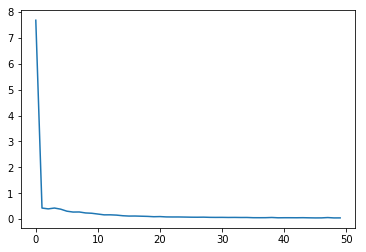

In [7]:
#step 9b_b
import matplotlib.pyplot as plt
def train_cnn(data_loader,save_string,epochs):
    model_cnn = FancyCNN()
    batch_size=16
    output_dim = 1

    model_cnn.to(device)
    lr=0.001
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_cnn.parameters(), lr=lr,weight_decay=0.0001)

    train_loss_min = np.Inf
    loss_values_train = []
    loss_values_val = []
    model_cnn.train()
    counter=0
    


    model_cnn.train()    
    for i in range(epochs):
        running_loss_train=0.0
        running_loss_val=0.0
        train_losses=[]
        for inputs, labels,lengths in data_loader:
            inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
            counter += 1
            model_cnn.zero_grad()
            output =  model_cnn(inputs.float())
            loss1= criterion(output.squeeze()[:,0], labels.float()[:,0])
            loss2= criterion(output.squeeze()[:,1], labels.float()[:,1])
            loss3= criterion(output.squeeze()[:,2], labels.float()[:,2])
            loss=0.4*loss1+0.3*loss2+0.3*loss3
            running_loss_train =+ loss.item() * batch_size
            train_losses.append(loss.item())

            loss.backward()

            optimizer.step()


        model_cnn.eval()
        model_cnn.train()
        print("Epoch: {}/{}...".format(i+1, epochs),
                "Step: {}...".format(counter),
                "Train Loss: {:.6f}...".format(loss.item()))
        loss_values_train.append(np.mean(train_losses))
        if np.mean(train_losses)<train_loss_min:
            torch.save(model_cnn.state_dict(),save_string)
    plt.plot(range(epochs),loss_values_train)
    #torch.save(model_cnn.state_dict(),save_string)
    
train_cnn(train_loader_multi,'state_mel_dict.pt',50)

In [8]:
#we will now test our cnn model for the mutitask dataset
import scipy.stats


def test_cnn_model_multitask(test_loader,save_file):
    model_cnn=FancyCNN()
    model_cnn.to(device)
    model_cnn.load_state_dict(torch.load(save_file))
    batch_size=5
    test_losses = []
    y_pred_test_1,y_pred_test_2,y_pred_test_3 = [], [], []
    y_true_1,y_true_2,y_true_3 = [], [], []
    model_cnn.eval()
    for inputs, labels,lengths in test_loader:
          inputs,labels,lengths= inputs.to(device), labels.to(device),lengths.to(device)
          output = model_cnn(inputs.float())
          y_pred_test_1.append(output.data[:,0].tolist())
          y_true_1.append(labels[:,0].tolist())
          y_pred_test_2.append(output.data[:,1].tolist())
          y_true_2.append(labels[:,1].tolist())
          y_pred_test_3.append(output.data[:,2].tolist())
          y_true_3.append(labels[:,2].tolist())
    rho1= scipy.stats.spearmanr(np.array(y_true_1).flatten(),np.array(y_pred_test_1).flatten()).correlation
    rho2= scipy.stats.spearmanr(np.array(y_true_2).flatten(),np.array(y_pred_test_2).flatten()).correlation
    rho3= scipy.stats.spearmanr(np.array(y_true_3).flatten(),np.array(y_pred_test_3).flatten()).correlation
    print('\nTest set: Spearman Correlation: {:.6f} \n'.format((rho1+rho2+rho3)/3))
    print(rho1,rho2,rho3)
test_cnn_model_multitask(test_loader_multi,'state_mel_dict.pt')


Test set: Spearman Correlation: 0.714508 

0.6188217112057082 0.7659793005536225 0.7587220662621901


In [9]:
#step 10

class CustomDataset(Dataset):
    def __init__(self, path,max_length=-1, read_spec_fn=read_mel_spectrogram):
        p = os.path.join(path, 'test')
        self.files = self.get_files()
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)

    def get_files(self):
        files = []
        for dirname,_,filenames in os.walk('/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset/test'):
            for filename in filenames:
                npy_file = filename
                files.append(npy_file)
        return files

    def __getitem__(self, item):
        # TODO: Inspect output and comment on how the output is formatted
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.files[item], l

    def __len__(self):
        return len(self.files)

In [10]:

model_cnn=FancyCNN()
model_cnn.to(device)
model_cnn.load_state_dict(torch.load('state_mel_dict.pt'))
batch_size=1
out = open('solution.txt', "w")

dataset = CustomDataset('../input/patreco3-multitask-affective-music/data/multitask_dataset/')

custom_test_loader = DataLoader(dataset,
                                batch_size=1,
                                drop_last=False)

out.write("Id.fused.full.npy.gz,valence,energy,danceability\n") #Id.fused.full.npy.gz was replaced with Id in the csv file
model_cnn.eval()
for inputs,files,lengths in custom_test_loader:
    inputs,lengths= inputs.to(device),lengths.to(device)
    output = model_cnn(inputs.float())
    out.write('%s,%f,%f,%f\n' % (files[0],output.data[:,0].tolist()[0],output.data[:,1].tolist()[0],output.data[:,2].tolist()[0]))
out.close()
              
    
    